<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/Turb_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple diffusion model to generate turbulent density slices
-- Uses the Denoising Diffusion Implicit Model (DDIM) pipeline via Hugging Face: https://huggingface.co/docs/diffusers/api/pipelines/ddim

-- Currently set up to train on the subsonic MHD turbulent box simulations with initial plasma beta ~ 1 (Bustard and Oh 2023)



In [ ]:
#@title Import packages and download data { display-mode: "form" }

# see what type of GPU we have
!nvidia-smi -L  

# import packages, download turbulence snapshots, etc.
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

!pip install cmasher
!pip install torchmetrics

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# download data from Google Drive
!pip install --upgrade gdown
import gdown

# Path for the FULL google drive file with turb sim data
# url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

# Path for the smaller turb sim data files (without augmentation)
#url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

# Path for the MHD_beta1 files, including density, magnetic_energy_density, etc.
url = "https://drive.google.com/drive/folders/1034U-07IQS99Ef2WCV5XrHOmAj2dM1nL"

#if not os.path.exists("Image_Cubes_noAugment"):
if not os.path.exists("MHD_beta1"):
  gdown.download_folder(url)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 KB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 36.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


Retrieving folder list


Processing file 1_lUNct09dsUAAM8y2jeuvo5xaKXD1z_y data_MHD_beta1_density_noAugment.npy
Processing file 1LKIvTQXh55OAn8DR1xpZx9jVJsSGQp7o data_MHD_beta1_magnetic_energy_density_noAugment.npy
Building directory structure completed


Retrieving folder list completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1_lUNct09dsUAAM8y2jeuvo5xaKXD1z_y
To: /content/MHD_beta1/data_MHD_beta1_density_noAugment.npy
100%|██████████| 1.07G/1.07G [00:04<00:00, 225MB/s]
Downloading...
From: https://drive.google.com/uc?id=1LKIvTQXh55OAn8DR1xpZx9jVJsSGQp7o
To: /content/MHD_beta1/data_MHD_beta1_magnetic_energy_density_noAugment.npy
100%|██████████| 1.07G/1.07G [00:05<00:00, 192MB/s]
Download completed


## Preprocess the data
We can train on either the density or magnetic energy density, but we don't need the simulation labels. In the future, we want to train on *both* and map from one to the other.

In [ ]:

# Specify which simulations we want to train on
#fileDirArr = ['MHD_beta1','MHD_beta10','MHD_beta100']
fileDirArr = ['MHD_beta1'] # try just one for now

field_list = ['density','magnetic_energy_density']

# read in fields
lbl = 0
for fileDir in fileDirArr:
    # load density
    filename = f"/data_{fileDir}_{field_list[0]}_noAugment.npy"
    x = np.load(fileDir + filename, mmap_mode='c') # the images
    x = np.float32(x)

    # load magnetic energy density
    filename = f"/data_{fileDir}_{field_list[1]}_noAugment.npy"
    y = np.load(fileDir + filename, mmap_mode='c') # the images
    y = np.float32(y)

    # assign a class value to each image depending on which simulation it came from
    # (e.g. 0 for beta = 1, 1 for beta = 10, 2 for beta = 100)
    z = np.ones(x.shape[2])*lbl # label these images by lbl

    if lbl==0:
      x_full = x
      y_full = y
      z_full = z
    else:
      x_full = np.concatenate([x_full,x],axis=2)
      y_full = np.concatenate([y_full,y],axis=2)
      z_full = np.concatenate([z_full,z])
      # plt.hist(y_full) # show histogram of data
      # plt.title(f"Full labels after {fileDir} added")
      # plt.show()

    lbl+=1

# x needs to have a channel column, i.e. x will be in format (N,C,H,W)
# x and y need to have the same first dimension 

def add_channel(x_full):
  x_with_channel = (torch.from_numpy(x_full).permute(2,0,1))
  x_channel_shape = x_with_channel.shape
  x_with_channel = x_with_channel.reshape(-1,1,x_channel_shape[1],x_channel_shape[2])
  return x_with_channel

x_with_channel = add_channel(x_full)
y_with_channel = add_channel(y_full)

z_full = torch.from_numpy(z_full)
z_full = z_full.type(torch.LongTensor) # throws error unless label is a LongTensor (64)

# Combine into TensorDataset
full_data = TensorDataset(x_with_channel, y_with_channel)

### Split into training, validation, and test datasets
Note: Right now the validation and test sets aren't being used in any way. Instead, the "test" is that random noise can be generated into a reasonable-looking density map given the training data it has seen.


In [ ]:
# split into training (60%), validation (20%), and test (20%) sets
# should eventually replace this in case slices "know" about each other due to spatial correlations

generator = torch.Generator()
generator.manual_seed(39) # set seed for reproducability
train_data,val_data,test_data = random_split(full_data,[0.6,0.2,0.2],generator=generator)

print(f"Length of Training Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")
print(f"Length of Test Data : {len(test_data)}")

# load batches of training and validation data
# the validation data batch size is twice as large because no backprop is needed

batch_size=16

#load the train and validation into batches.
train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(val_data, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_data, batch_size*2, num_workers = 4, pin_memory = True)

Length of Training Data : 4916
Length of Validation Data : 1638
Length of Test Data : 1638


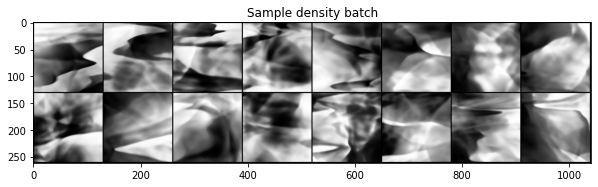

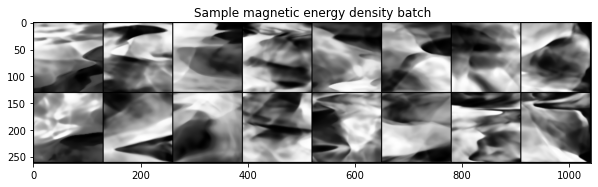

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def batch_imshow(img, title):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.imshow(np.transpose( img.detach().cpu().numpy(), (1, 2, 0)), cmap='gray')
    plt.show()

for i, data in enumerate(train_dl):
    x, y = data  
    batch_imshow(make_grid(x, 8), title = 'Sample density batch')
    batch_imshow(make_grid(y, 8), title = 'Sample magnetic energy density batch')
    break  # we need just one batch

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


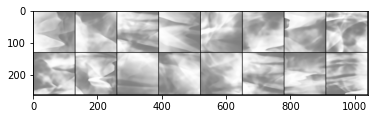

In [ ]:
# Using PIL
from PIL import Image
import torchvision

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

for i, data in enumerate(train_dl):
    x, y = data  
    grid = show_images(x)
    plt.imshow(grid)
    break

## Diffusion model

In [ ]:
!pip install diffusers[training]==0.11.1 # from hugging face

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 KB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.5 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = batch_size
    eval_batch_size = batch_size  # how many images to sample during evaluation
    num_epochs = 3
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 50
    save_image_epochs = 1
    save_model_epochs = 1
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'turb_density_10epochs_100steps'  # the model namy locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_private_repo = False  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [1]:
from diffusers import UNet2DModel

"""
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",  
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D",  
      ),
)

"""
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

# Make sure the input shape matches the output shape
sample_image = x_with_channel[0].unsqueeze(0)
output_shape = model(sample_image,timestep=0).sample.shape
if (sample_image.shape == output_shape):
  print("Input and output shapes match!")
else:
  print("Error: U-net output shape doesn't match image input shape")
  print('Input shape:', sample_image.shape)
  print('Output shape:', model(sample_image, timestep=0).sample.shape)
  




ModuleNotFoundError: ignored

### Training


In [ ]:
from diffusers.optimization import get_cosine_schedule_with_warmup

#from diffusers import DDPMScheduler
from diffusers import DDIMScheduler

#noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise_scheduler = DDIMScheduler(num_train_timesteps=100)


optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dl) * config.num_epochs),
)

from diffusers import DDPMPipeline, DDIMPipeline
from PIL import Image
import math

# need to output image grid to then be saved to file
#def batch_save_images(img, title):
#    plt.figure(figsize=(10, 10))
#    plt.title(title)
#    plt.imshow(np.transpose( img.numpy(), (1, 2, 0)), cmap='gray')
    #test_dir = os.path.join(config.output_dir, "samples")
    #os.makedirs(test_dir, exist_ok=True)
    #image_grid.save(f"{test_dir}/{epoch:04d}.png")
    # plt.save(f"{test_dir}/{epoch:04d}.png")

# rows and cols not currently used...
# def show_images(x, rows, cols):
#    """Given a batch of images x, make a grid and convert to PIL"""
#    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
#    grid = torchvision.utils.make_grid(x, nrow=rows)
#    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
#    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
#    return grid_im


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    #batch_save_images(make_grid(images, 8), title = 'Sample density batch')
    #image_grid = show_images(images, rows=int(batch_size/2), cols=int(batch_size/2))
    #image_grid = make_grid(images, rows=int(batch_size/2), cols=int(batch_size/2))

    # Save the images
    #test_dir = os.path.join(config.output_dir, "samples")
    #os.makedirs(test_dir, exist_ok=True)
    #image_grid.save(f"{test_dir}/{epoch:04d}.png")


## Set up the training loop


In [ ]:
# Set up the training loop

# This xformers package, which is supposed to help decrease memory usage,
# doesn't seem to work with a DDIM pipeline? 
!pip install xformers==0.0.17.dev461

import xformers

from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        logging_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    losses = []

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images, _ = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)
                losses.append(loss.item())

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            #pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            pipeline = DDIMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)
            
            # This next line doesn't seem to work...
            #pipeline.enable_xformers_memory_efficient_attention()

            # optimizations 
            #pipeline.enable_model_cpu_offload() # put some components on CPU until they're needed
            #pipeline.enable_attention_slicing(1) # decrease RAM at expense of 10% slowdown

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)
                
                loss_last_epoch = sum(losses[-len(train_dl) :]) / len(train_dl)
                print(f"Epoch:{epoch}, loss: {loss_last_epoch}")

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Train!

In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dl, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
from google.colab import files
files.download(config.output_dir)

In [ ]:
import torchvision

def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

# start with random noise and create an image
# Random starting point (8 random images):
sample = torch.randn(8, 1, 128, 128).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

TypeError: ignored

0it [00:00, ?it/s]

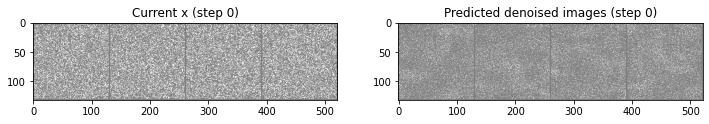

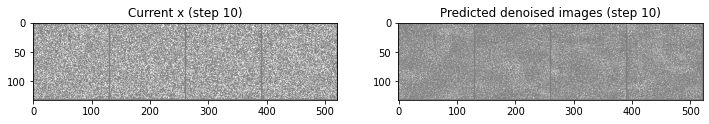

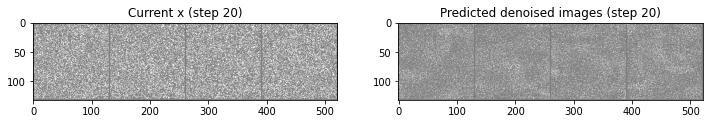

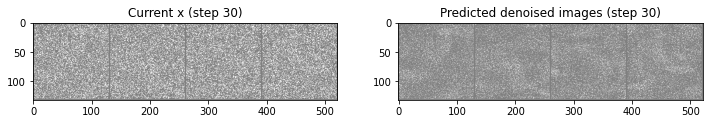

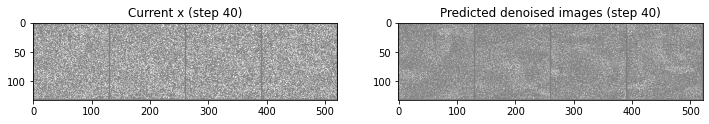

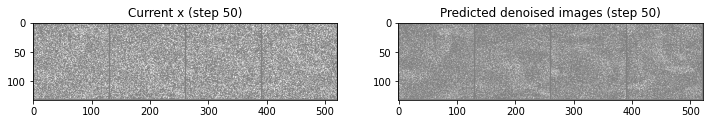

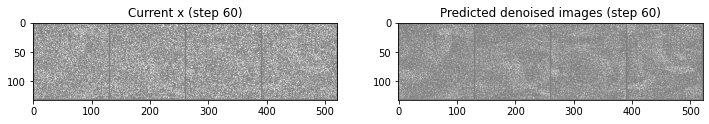

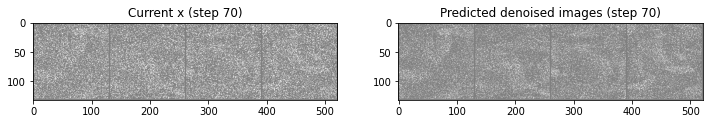

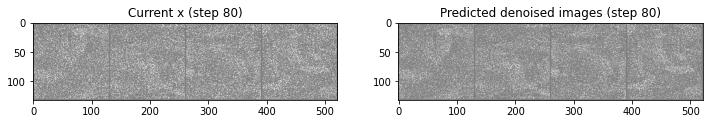

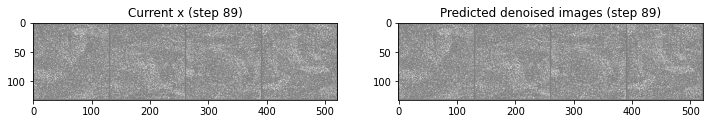

In [ ]:
# Another way to view upsampling over time
#

image_pipe = DDIMPipeline.from_pretrained(config.output_dir)
image_pipe.to(device)

scheduler = DDIMScheduler.from_pretrained(config.output_dir+'/scheduler')
scheduler.set_timesteps(num_inference_steps=90)

# The random starting point
x = torch.randn(4, 1, 128, 128).to(device)  # Batch of 4, 1-channel 128 x 128 px images
#scheduler = noise_scheduler

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(0, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(0, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i})")
        plt.show()